In [12]:
from vnstock import Quote
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import stats


In [6]:
def get_stock_data(symbols, start_date, end_date, interval="1D"):
    """
    Fetch historical stock data for multiple symbols and save to CSV files
    
    Parameters:
    -----------
    symbols : list
        List of stock symbols
    start_date : str
        Start date in 'YYYY-MM-DD' format
    end_date : str
        End date in 'YYYY-MM-DD' format
    interval : str, default='1D'
        Time interval for data ('1D' for daily, '1W' for weekly, etc.)
    
    Returns:
    --------
    dict
        Dictionary containing DataFrames for each symbol
    """
    data_dict = {}
    
    for symbol in symbols:
        quote = Quote(symbol=symbol, source="VCI")
        df = quote.history(start=start_date, end=end_date, interval=interval)
        data_dict[symbol] = df
       # Save to CSV with dynamic filename
        filename = f"../data/{symbol}.csv"
        df.to_csv(filename)
        print(f"Saved data for {symbol} to {filename}")
    
    return data_dict

# Example usage:
symbols = ["FPT", "VNM", "VCB", "MBB", "VCG", "NTP"]
data = get_stock_data(symbols, "2022-01-01", "2025-06-10")

Saved data for FPT to ../data/FPT.csv
Saved data for VNM to ../data/VNM.csv
Saved data for VCB to ../data/VCB.csv
Saved data for MBB to ../data/MBB.csv
Saved data for VCG to ../data/VCG.csv
Saved data for NTP to ../data/NTP.csv


In [7]:
#import mbb data
df = pd.read_csv("../data/MBB.csv")

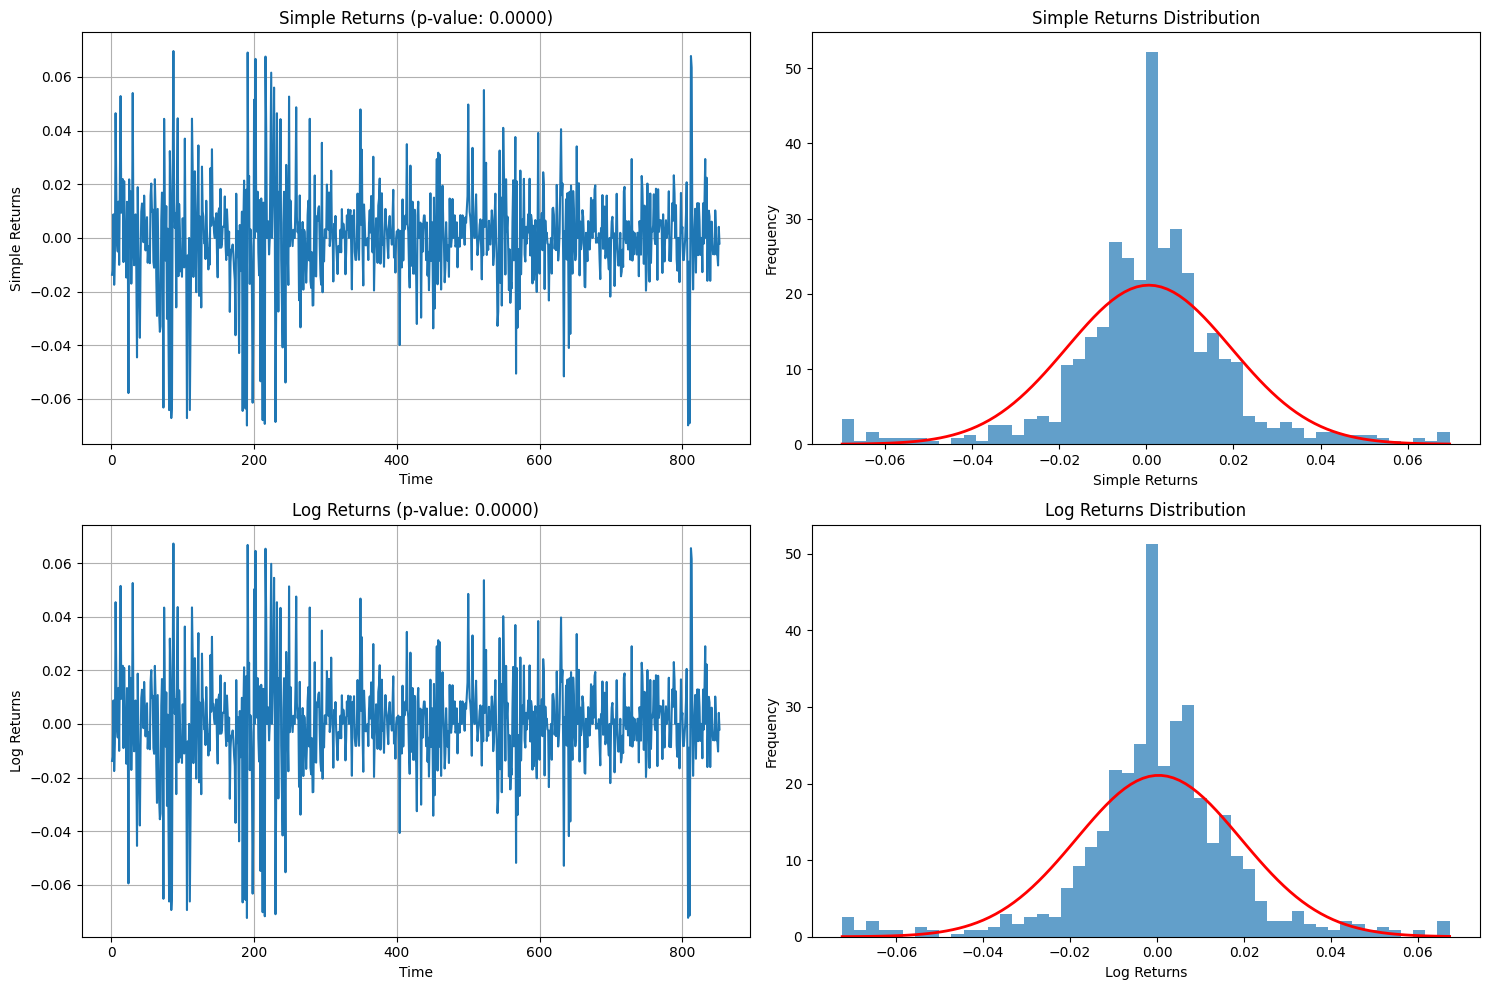

Simple returns ADF test p-value: 0.0000
Log returns ADF test p-value: 0.0000

Interpretation:
p-value < 0.05 indicates stationarity
p-value >= 0.05 indicates non-stationarity


In [17]:
def analyze_stock_returns(df):
    """
    Analyze and visualize stock returns before and after log transformation
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing stock data with 'close' column
    """
    # Sort data by time
    df = df.sort_values(by="time")
    
    # Calculate simple returns and log returns
    df['simple_return'] = df['close'].pct_change()
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    simple_returns = df['simple_return'].dropna()
    log_returns = df['log_return'].dropna()
    
    # Perform stationarity tests
    simple_test = adfuller(simple_returns)
    simple_pvalue = simple_test[1]
    
    log_test = adfuller(log_returns)
    log_pvalue = log_test[1]
    
    # Create figure with 2x2 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot simple returns
    ax1.plot(simple_returns)
    ax1.set_title(f'Simple Returns (p-value: {simple_pvalue:.4f})')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Simple Returns')
    ax1.grid(True)
    
    # Plot simple returns histogram with normal curve
    ax2.hist(simple_returns, bins=50, density=True, alpha=0.7)
    x = np.linspace(simple_returns.min(), simple_returns.max(), 100)
    mu = simple_returns.mean()
    sigma = simple_returns.std()
    ax2.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2)
    ax2.set_title('Simple Returns Distribution')
    ax2.set_xlabel('Simple Returns')
    ax2.set_ylabel('Frequency')
    
    # Plot log returns
    ax3.plot(log_returns)
    ax3.set_title(f'Log Returns (p-value: {log_pvalue:.4f})')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Log Returns')
    ax3.grid(True)
    
    # Plot log returns histogram with normal curve
    ax4.hist(log_returns, bins=50, density=True, alpha=0.7)
    x = np.linspace(log_returns.min(), log_returns.max(), 100)
    mu = log_returns.mean()
    sigma = log_returns.std()
    ax4.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2)
    ax4.set_title('Log Returns Distribution')
    ax4.set_xlabel('Log Returns')
    ax4.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Print stationarity test results
    print(f"Simple returns ADF test p-value: {simple_pvalue:.4f}")
    print(f"Log returns ADF test p-value: {log_pvalue:.4f}")
    print("\nInterpretation:")
    print("p-value < 0.05 indicates stationarity")
    print("p-value >= 0.05 indicates non-stationarity")
    
    return log_returns

# Example usage:
returns = analyze_stock_returns(df)

In [5]:
mu_r = returns.mean()
sigma_r = returns.std()
print(f"Profit_expected_day: {mu_r*252:.6f}")
print(f"Standard_dev_day: {sigma_r*np.sqrt(252):.6f}")


NameError: name 'returns' is not defined

In [5]:
simulations = 1000000      # số lần mô phỏng
days = 126               # số ngày giao dịch trong 1 năm
start_price = df['close'].iloc[-1]  # giá hiện tại (ngày cuối cùng trong dữ liệu)

# Mô phỏng log returns ngẫu nhiên
simulated_returns = np.random.normal(mu_r, sigma_r, (simulations, days))

# Tính giá tương lai từ log returns
price_paths = start_price * np.exp(np.cumsum(simulated_returns, axis=1))

In [6]:
final_prices = price_paths[:, -1]
returns_1y = (final_prices - start_price) / start_price

# Thống kê
expected_return = np.mean(returns_1y)
risk = np.std(returns_1y)
VaR_5 = np.percentile(returns_1y, 5)

print(f"Lợi nhuận kỳ vọng sau 1 năm: {expected_return:.2%}")
print(f"Độ lệch chuẩn lợi nhuận (Rủi ro): {risk:.2%}")
print(f"Value-at-Risk (VaR 5%): {VaR_5:.2%}")

Lợi nhuận kỳ vọng sau 1 năm: 3.25%
Độ lệch chuẩn lợi nhuận (Rủi ro): 24.78%
Value-at-Risk (VaR 5%): -31.96%


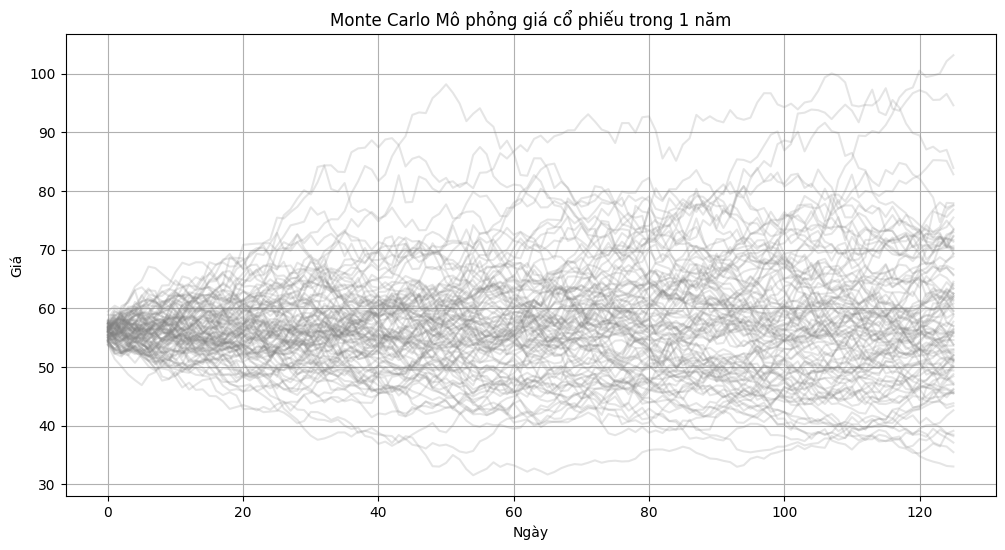

In [7]:
plt.figure(figsize=(12,6))
for i in range(100):  # Vẽ 100 đường mô phỏng
    plt.plot(price_paths[i], color='grey', alpha=0.2)

plt.title("Monte Carlo Mô phỏng giá cổ phiếu trong 1 năm")
plt.xlabel("Ngày")
plt.ylabel("Giá")
plt.grid(True)
plt.show()

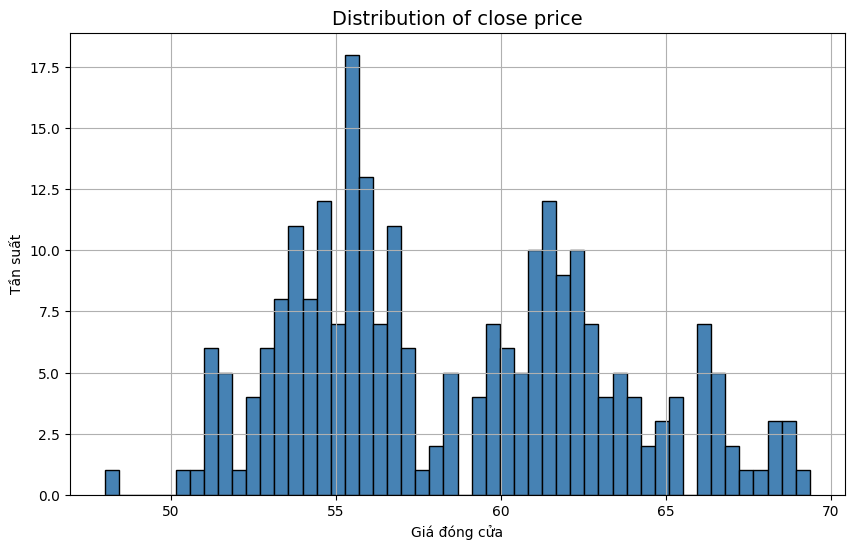

In [8]:

# Historical plot
plt.figure(figsize=(10, 6))
plt.hist(df['close'], bins=50, color='steelblue', edgecolor='black')
plt.title('Distribution of close price', fontsize=14)
plt.xlabel('Giá đóng cửa')
plt.ylabel('Tần suất')
plt.grid(True)
plt.show()


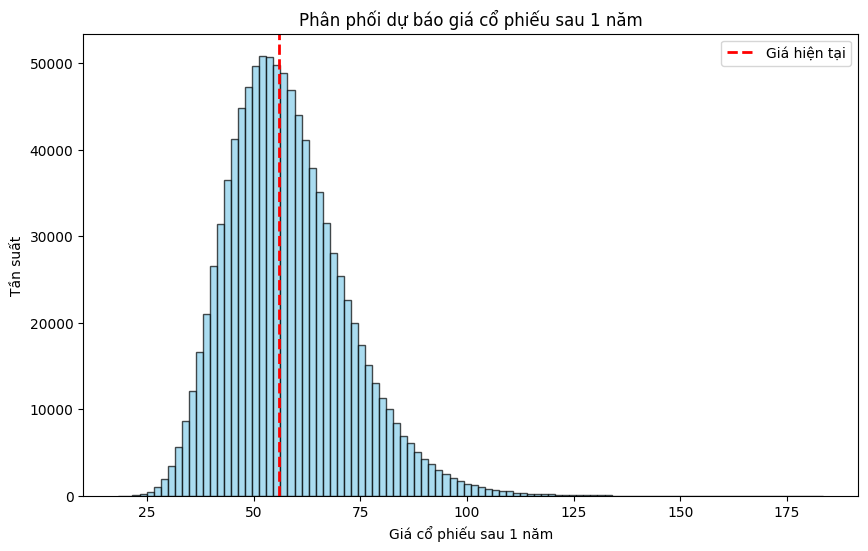

In [9]:
simulated_returns = np.random.normal(mu_r, sigma_r, (simulations, days))

# Tính đường giá dự báo
price_paths = start_price * np.exp(np.cumsum(simulated_returns, axis=1))

# Giá sau 1 năm
final_prices = price_paths[:, -1]

# Vẽ biểu đồ phân phối
plt.figure(figsize=(10, 6))
plt.hist(final_prices, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(start_price, color='red', linestyle='dashed', linewidth=2, label="Giá hiện tại")
plt.xlabel("Giá cổ phiếu sau 1 năm")
plt.ylabel("Tần suất")
plt.title("Phân phối dự báo giá cổ phiếu sau 1 năm")
plt.legend()
plt.show()